In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sqlalchemy

from dtaidistance import dtw
from scipy import stats

from database_credentials import get_database_url
from load_transform import load_transform_combine, pivot
from sampling import get_sample_trends

In [2]:
def get_number_of_components(graph, component_size):
    """Get the number of components within a graph
    
    Args: 
        graph (networkx graph):
            contains nodes representing trend_ids
            and edges representing dtw distances
            
        component_size (int):
            determines the size of components 
            included within the count
    
    Returns:
        num_components (int):
            number of components within the graph
    """
    
    graph_components = nx.connected_components(graph)
    
    components = [
        component for component in graph_components 
        if len(component) >= component_size
    ]

    num_components = len(components)
    return num_components

In [3]:
plt.style.use('ggplot')
sns.set_style('white')

In [4]:
database_url = get_database_url()
engine = sqlalchemy.create_engine(database_url)
connection = engine.connect()

In [5]:
num_weeks = 5
sell_data = load_transform_combine(num_weeks, connection)
xticks = sell_data['weekday_observed'].unique()

trends = pivot(sell_data)
trends = trends.to_numpy()

In [6]:
# standardize using z-score
trends = stats.zscore(trends)
num_trends = trends.shape[0]

distances = np.zeros((num_trends, num_trends))
graph = nx.Graph()

# compute pairwise distances, build complete graph, save distances
for x, y in np.ndindex(distances.shape):
    if (x > y):
        distance = dtw.distance(trends[x], trends[y])
        graph.add_weighted_edges_from([(x, y, distance)])
        distances[x][y] = distance
        distances[y][x] = distance

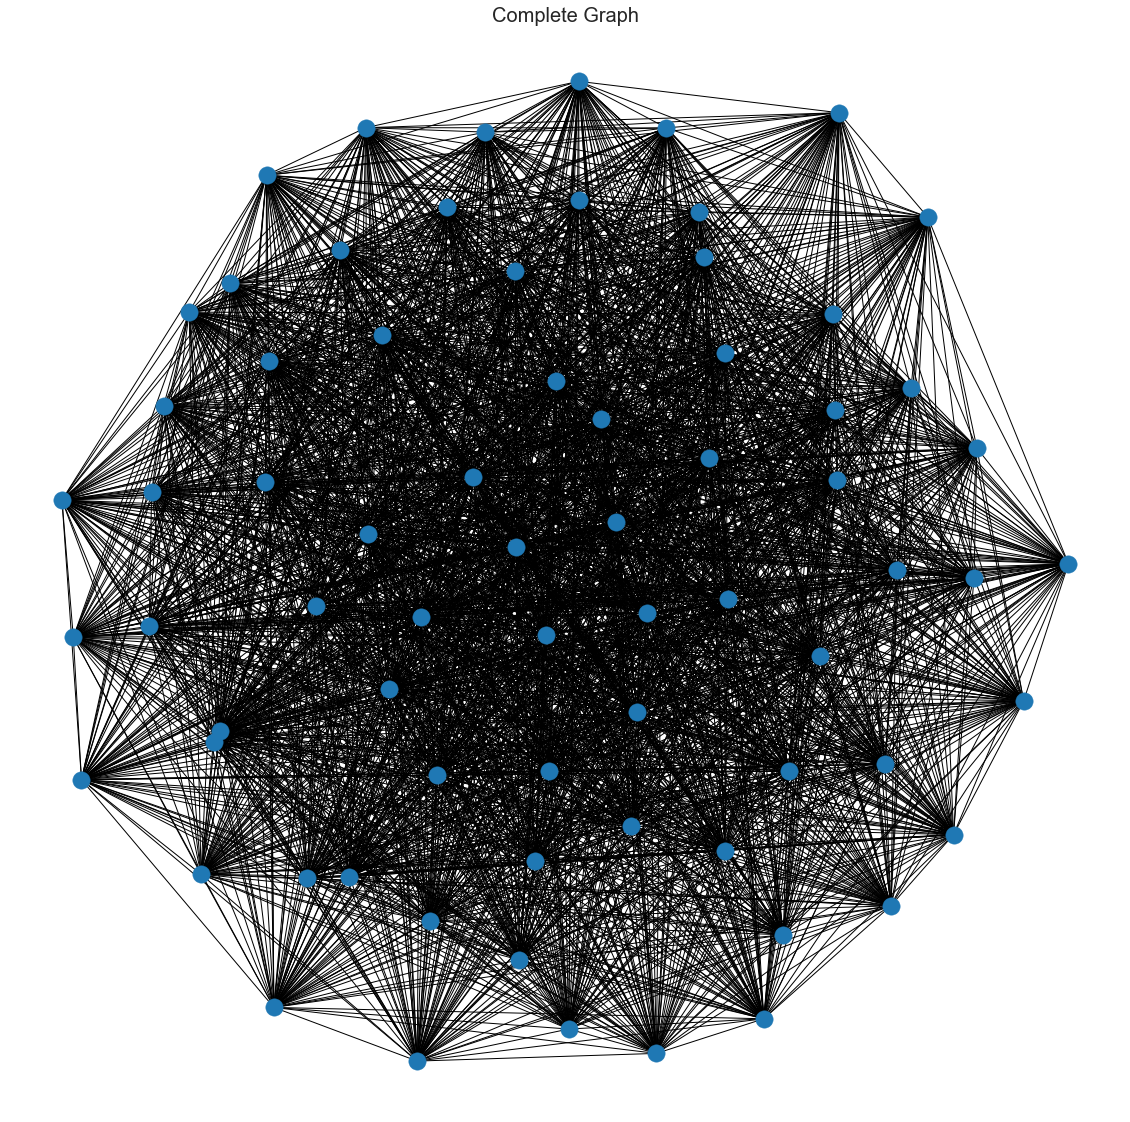

In [7]:
plt.figure(figsize=(20, 20))
plt.title('Complete Graph', fontsize=20)
nx.draw(graph)
plt.show()

In [8]:
min_distance = distances.min()
max_distance = distances.max()

weights = np.linspace(min_distance, max_distance, 1000)
weights = weights[::-1] # reverse to remove edges with larger weights first

graph_copy = graph.copy()

# number of components corresponding to a weight
components = []
significant_components = []

for weight in weights:
    edges = graph_copy.edges(data=True)
    edges_beyond_cutoff = [
        edge for edge in edges 
        if edge[2]['weight'] > weight
    ]
    
    graph_copy.remove_edges_from(edges_beyond_cutoff)
    
    num_components = get_number_of_components(
        graph_copy, component_size=1
    )
    num_significant_components = (
        get_number_of_components(graph_copy, component_size=3)
    )
    
    components.append(num_components)
    significant_components.append(num_significant_components)

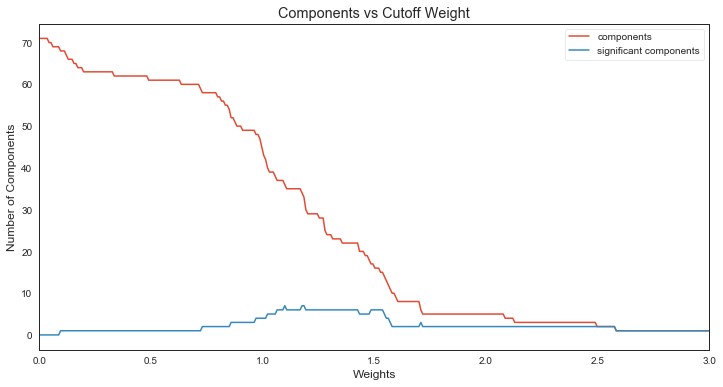

In [9]:
plt.figure(figsize=(12, 6))
plt.title('Components vs Cutoff Weight')

component_plot = sns.lineplot(
    x=weights, 
    y=components
)
significant_component_plot = sns.lineplot(
    x=weights, 
    y=significant_components
)

plt.legend(['components', 'significant components'])
plt.xlabel('Weights')
plt.xlim(0, 3)
plt.ylabel('Number of Components')
plt.show()

In [10]:
max_significant_components = max(significant_components)
max_index = significant_components.index(max_significant_components)
cutoff_weight = weights[max_index]

In [11]:
remove = [
    edge for edge in graph.edges(data=True) 
    if edge[2]['weight'] > cutoff_weight
]
graph.remove_edges_from(remove)

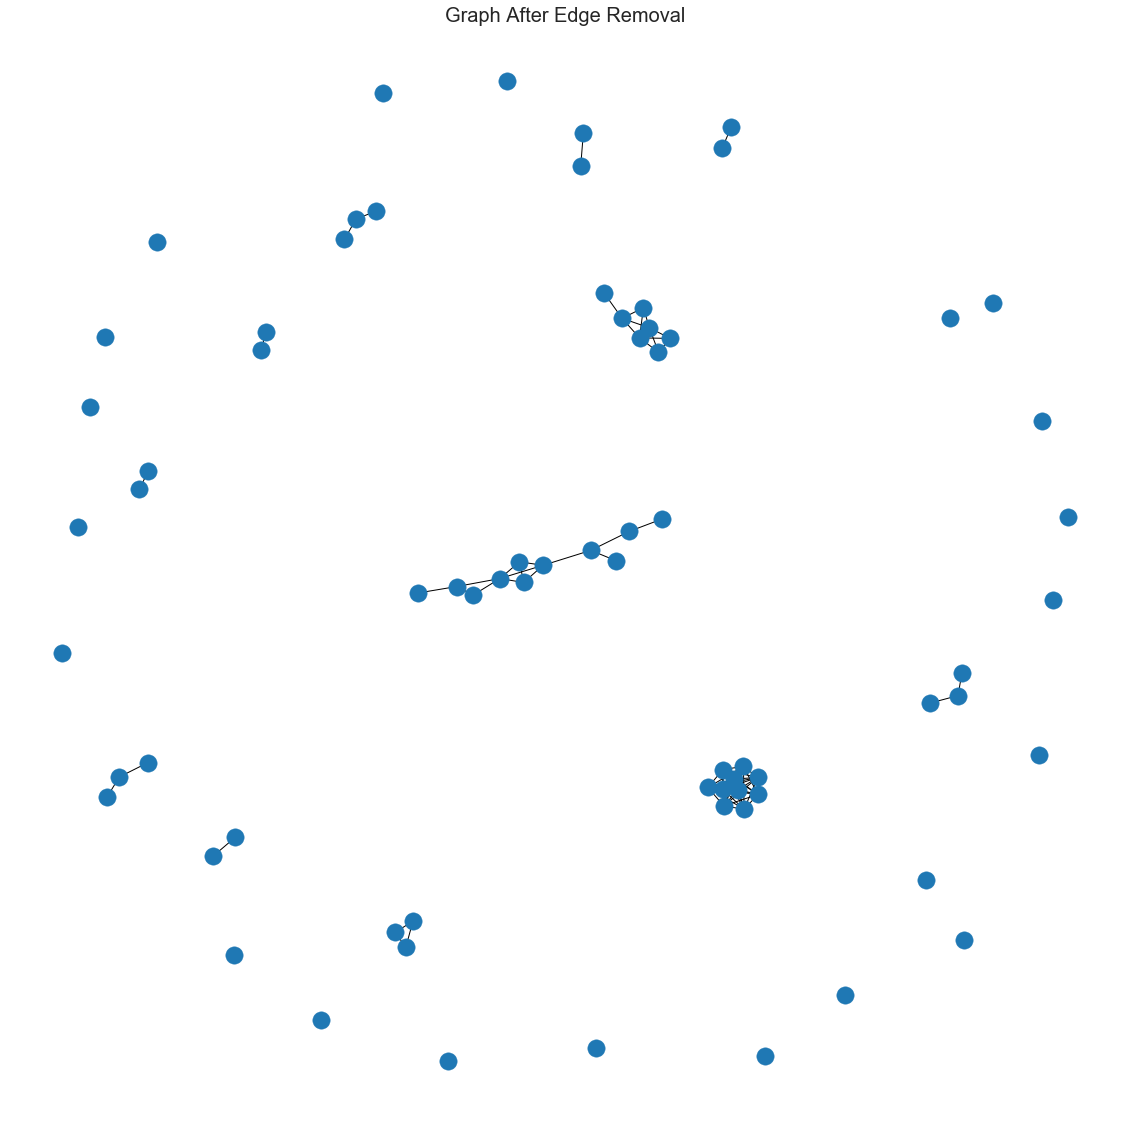

In [12]:
plt.figure(figsize=(20, 20))
plt.title('Graph After Edge Removal', fontsize=20)
nx.draw(graph)
plt.show()

In [13]:
trend_id_clusters = [
    np.array(list(component)) 
    for component in nx.connected_components(graph)
    if len(component) >= 3
]

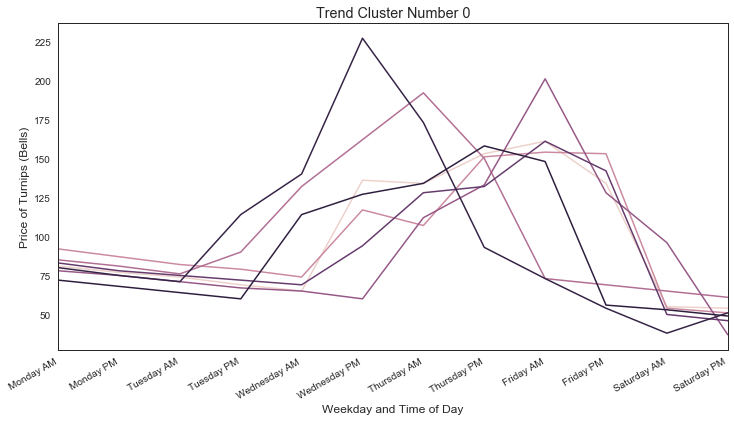

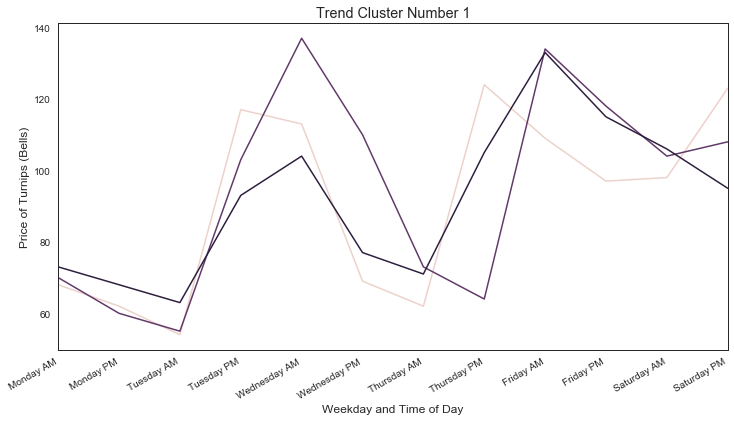

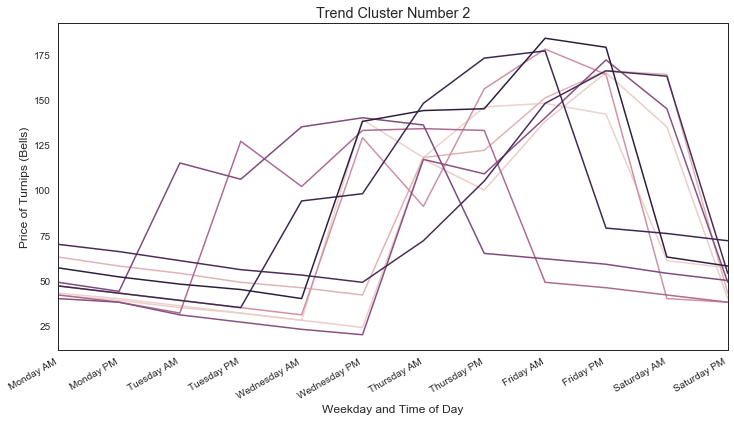

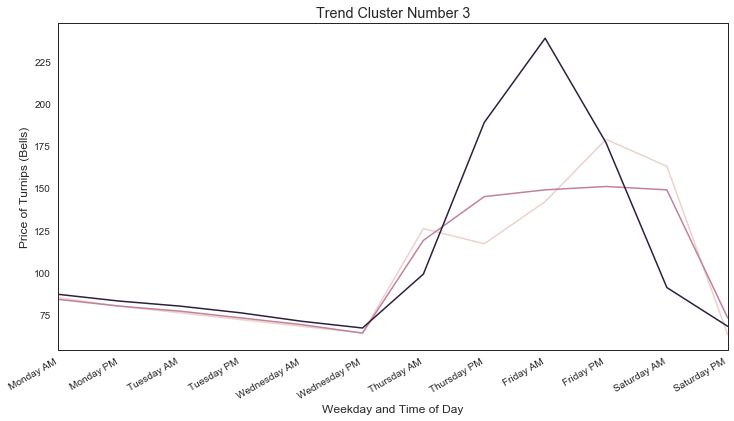

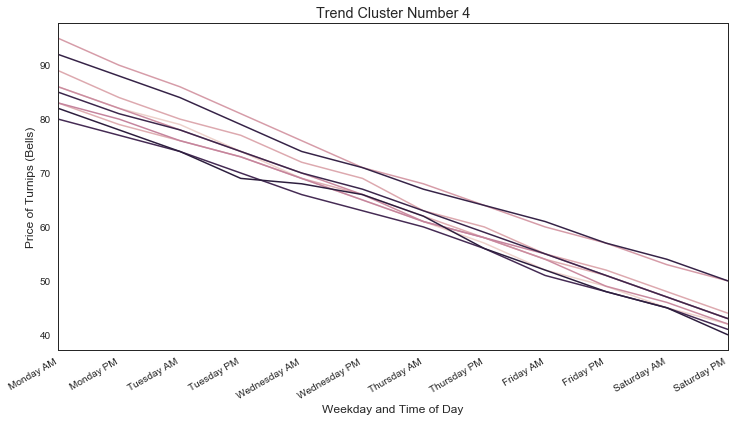

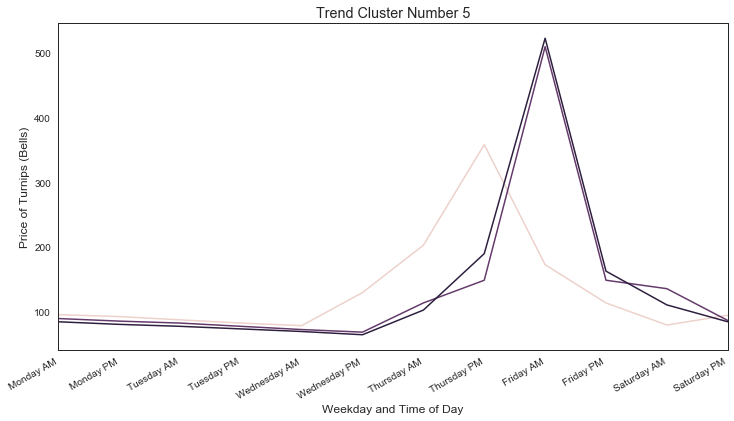

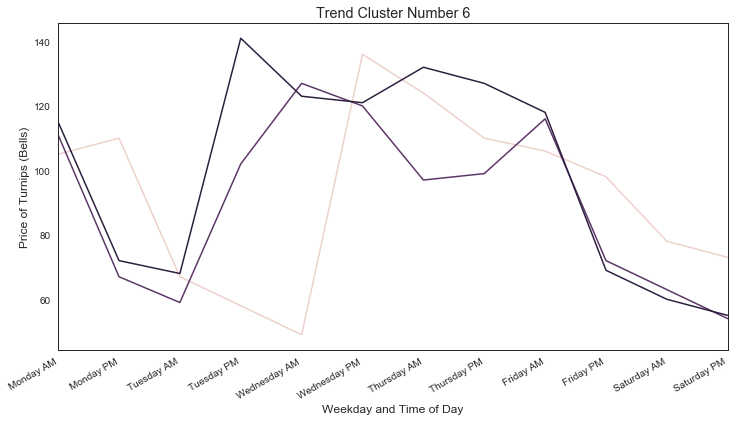

In [14]:
cluster_numbers = range(len(trend_id_clusters))
for trend_ids, cluster_number in zip(trend_id_clusters, cluster_numbers):
    sample_trends = get_sample_trends(sell_data, trend_ids, 10)
    plt.figure(figsize=(12, 6))
    trend_plot = sns.lineplot(
        x='weekday_observed', 
        y='price', 
        hue='trend_id',
        data=sample_trends, 
        sort=False,
        legend=False
    )
    trend_plot.set(
        title='Trend Cluster Number {0}'.format(cluster_number),
        xlabel='Weekday and Time of Day',
        ylabel='Price of Turnips (Bells)'
    )
    trend_plot.set_xticklabels(xticks, rotation=30, ha='right')
    plt.xlim(0, 11)
    plt.show()

In [15]:
for component in nx.connected_components(graph):
    print(component)

{64, 1, 38, 50, 21, 62, 30}
{0, 5}
{49, 2}
{57, 3, 46}
{4, 36}
{6}
{32, 70, 7, 8, 40, 42, 14, 53, 22, 55, 59}
{9, 58, 27}
{10, 23}
{11}
{12}
{13}
{15}
{16}
{65, 66, 35, 33, 68, 17, 25, 26, 29, 63}
{18}
{41, 19, 47}
{20}
{24}
{28}
{31}
{34, 43, 45}
{37}
{39}
{44}
{48}
{51, 61}
{52}
{54}
{56}
{60}
{67}
{69}
